# Obhod Lune
##### Andrej Jočić

## Omejen krožni problem treh teles

Označimo z $M$
 maso Zemlje in z $m$
 maso Lune. Ker je masa sonde zanemarljiva, Zemlja in Luna krožita okrog skupnega masnega središča. Enačbe gibanja zapišemo v vrtečem koordinatnem sistemu, kjer masi $M$
 in $m$
 mirujeta. Označimo
 
$\mu = \frac{m}{M+m}$ ter $\overline{\mu}=1-\mu=\frac{M}{M+m}$.

V brezdimenzijskih koordinatah (dolžinska enota je kar razdalja med masama $M$
 in $m$
) postavimo maso $M$
 v točko $(-\mu,0,0)$
, maso $m$
 pa v točko $(\overline{\mu},0,0)$
. Označimo z $R$
 in $r$
 oddaljenost satelita s položajem $(x,y,z)$
 od mas $M$
 in $m$
, tj.

$R=R(x,y,z)=\sqrt{(x+\mu)^2+y^2+z^2}$,

$r=r(x,y,z)=\sqrt{(x-\overline{\mu})^2+y^2+z^2}$.

Enačbe gibanja sonde so potem:

\begin{align}
    \ddot{x} &= x + 2\dot{y} - \frac{\overline{\mu}}{R^3}(x + \mu) - \frac{\mu}{r^3}(x - \overline{\mu}), \\
    \ddot{y} &= y - 2\dot{x} - \frac{\overline{\mu}}{R^3}y - \frac{\mu}{r^3}y, \\
    \ddot{z} &= -\frac{\overline{\mu}}{R^3}z - \frac{\mu}{r^3}z.
\end{align}

## Rešitev

Funkcija `solve_CR3BP(problem; init_pos, init_vel, duration, integrator_params)` izračuna tir sonde v omejenem krožnem problemu treh teles `problem` z danimi začetnimi pogoji za čas `duration`.
Integrator je določen s tipom `integrator_params`. Implementirali smo metodo Runge-Kutta reda 4 s fiksnim korakom ter metodo DOPRI5 z adaptivnim korakom. Slednja je bolj primerna za inherentno nestabilne probleme (kot je obravnavani), vendar zahteva več računanja v vsakem koraku.

Zgornji sistem enačb drugega reda prevedemo na sistem šestih enačb prvega reda z uvedbo novih spremenljivk $v_x(t)=\dot{x}(t)$, $v_y(t)=\dot{y}(t)$ ter $v_z(t)=\dot{z}(t)$. 
Sicer na levi strani enačbe (3) ne nastopajo prvi odvodi, torej bi za njo lahko uporabili npr. metodo Numerova, vendar smo zaradi enostavnosti implementacije naredili standardno pretvorbo sistema ter celotnega reševali z isto metodo.
V zgornjih enačbah čas ne nastopa eksplicitno (imamo *avtonomne* diferencialne enačbe), kar še nekoliko poenostavi implementacijo. 

## Primer uporabe

In [1]:
using CRThreeBodyProblem
using Plots, LinearAlgebra

Izračunajmo tir sonde, izstreljene iz orbite Lune proti Zemlji. Uporabimo metodo RK(4) s 1000 koraki na časovnem intervalu 2,48 obhodov Lune okoli Zemlje. 

In [2]:
earth_moon = CR3BP();

sol = solve_CR3BP(
    earth_moon,
    init_pos = earth_moon.pos2 + [0.0, 0.0455, 0.0], # slight y offset from moon
    init_vel = [-0.5, 0.5, 0.0],
    duration = 2π * 2.48,
    integrator_params = ParamsRK4(1000)
);

In [3]:
function plot_primary_secondary!(fig::Plots.Plot, system::CR3BP)
    scatter!(fig, [system.pos1[1]], [system.pos1[2]], label="Earth", color="blue", markersize=9, alpha=0.5)
    scatter!(fig, [system.pos2[1]], [system.pos2[2]], label="Moon", color="gray", markersize=4, alpha=0.5)
end

function plot_trajectory!(fig::Plots.Plot, sol::IVP_solution; label="Trajectory", cmap = :viridis, points_per_color = 100)
    if points_per_color > length(sol.t)
        points_per_color = length(sol.t)
    end
    ncolors = floor(Int, length(sol.t) / points_per_color)
    age_colors = cgrad(cmap, ncolors, categorical = true)
    positions = sol.y[points_per_color * ncolors, 1:2]

    for i in 1:ncolors
        start = (i-1)*points_per_color+1
        stop = i*points_per_color + 1
        if i < ncolors
            plot!(fig, sol.y[start:stop, 1], sol.y[start:stop, 2], color=age_colors[i], primary=false)
        else
            plot!(fig, sol.y[start:stop, 1], sol.y[start:stop, 2], color=age_colors[i], label="end of "*label, primary=true)
        end
    end

    plot!(
        fig,
        xlabel = "x", ylabel = "y",
        size=(600, 600), aspect_ratio=:equal, framestyle = :box
    )
end

plot_trajectory! (generic function with 1 method)

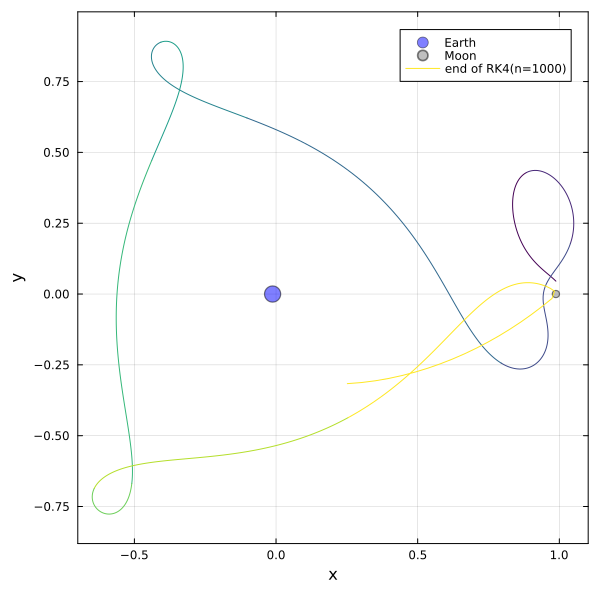

In [4]:
rk4_plot = plot()
plot_primary_secondary!(rk4_plot, earth_moon)
plot_trajectory!(rk4_plot, sol, label="RK4(n=1000)")
display(rk4_plot)

Ker sistem nima analitične rešitve, ne moremo izračunati napake. Lahko pa jo ocenimo tako, ponovimo izračun z dvakrat manjšim korakom in izračunamo razliko med rezultatoma. 

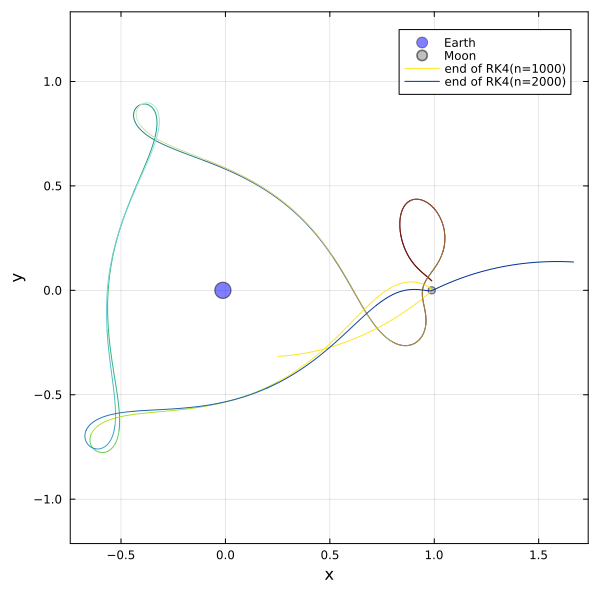

In [5]:
sol2 = solve_CR3BP(
    earth_moon,
    init_pos = earth_moon.pos2 + [0.0, 0.0455, 0.0], # slight y offset from moon
    init_vel = [-0.5, 0.5, 0.0],
    duration = 2π * 2.48,
    integrator_params = ParamsRK4(2 * 1000)
)
plot_trajectory!(rk4_plot, sol2, cmap=:roma, label="RK4(n=2000)")

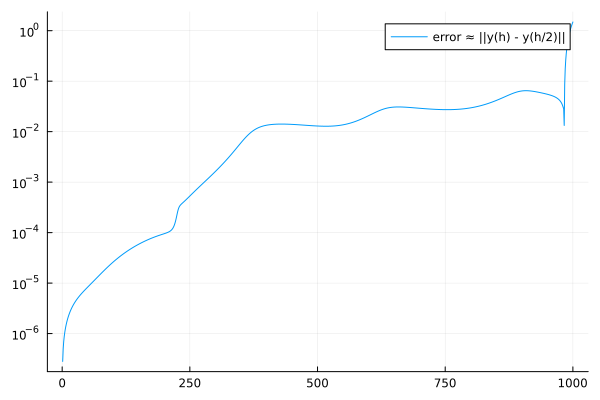

In [6]:
position_diff = sol.y[:, 1:3] - sol2.y[1:2:end, 1:3]
norms = [norm(position_diff[i, :]) for i in 1:size(position_diff, 1)]
plot( 
    norms[2:end], yscale=:log10, # skip first point because it's 0
    label="error ≈ ||y(h) - y(h/2)||",
    xlabel="time step"
) 

## Cirkumlunarni obhod

Radi bi našli začetne pogoje za izstrelitev sonde iz Zemljine orbite, da bo ta obkrožila Luno in se vrnila v Zemljino orbito (ali vsaj dovolj blizu, da npr. poberemo podatke preko radijskih valov). Žal nismo našli idealnih začetnih pogojev, smo pa uspeli narediti nekakšen dvojni "slingshot" manever okoli Zemlje, ki na koncu obkroži Luno.

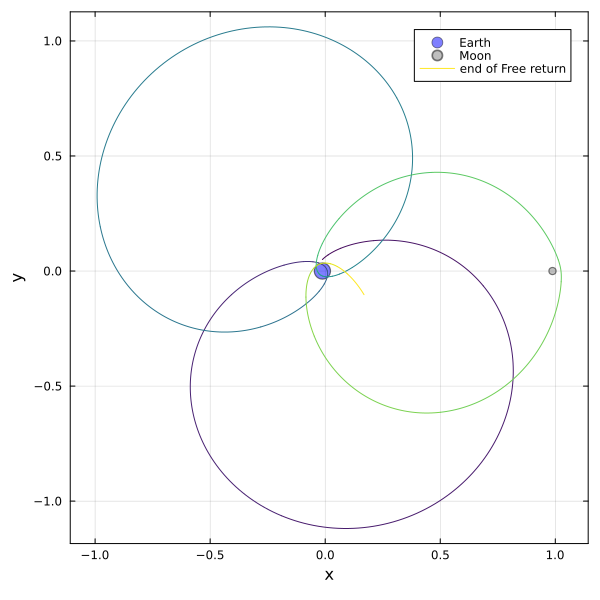

In [7]:
free_ret = solve_CR3BP(
    earth_moon,
    init_pos = earth_moon.pos1 + [0.0, 0.05, 0.0], # slight y offset from earth
    init_vel = [4.37, 4.37, 0.0],
    duration = 2π * 1.23,
    integrator_params = ParamsDOPRI5(ε = 1e-9, h0 = 0.01),
)

free_ret_plot = plot()
plot_primary_secondary!(free_ret_plot, earth_moon)
plot_trajectory!(free_ret_plot, free_ret, label="Free return")
display(free_ret_plot)

## Lagrangeeve točke

Lagraangeeve točke so točke v sistemu dveh teles (npr. Zemlja-Luna), kjer se njuni privlačni sili izničita. 
Točke L1, L2 in L3 so nestabilne, torej lahko sonda zaradi manjhne perturbacije (ali numerične napake v simulaciji) pobegne iz njihove okolice. 

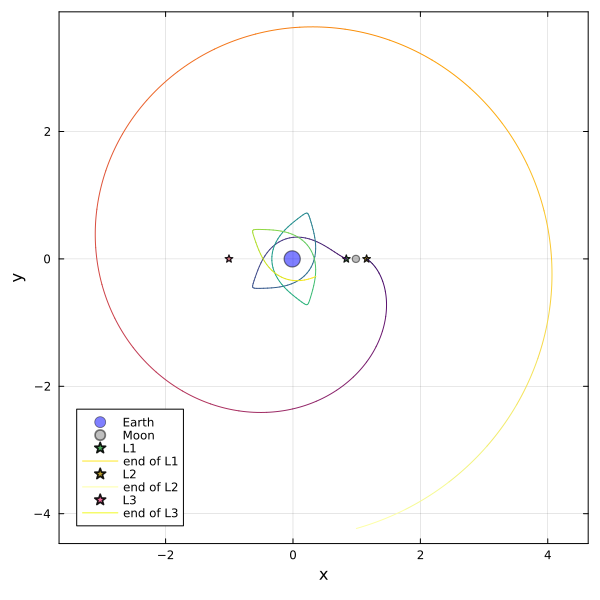

In [12]:
# https://orbital-mechanics.space/the-n-body-problem/Lagrange-points-example.html#example-plotting-lagrange-points
earth_Lx = [
     0.8369154703225321,
     1.1556818961296604,
    -1.0050626166357435,
];

lagrange_plot = plot()
plot_primary_secondary!(lagrange_plot, earth_moon)

cmaps = [:viridis, :inferno, :plasma]

for (i, Lx) in enumerate(earth_Lx)
    lp = [Lx, 0.0, 0.0]
    scatter!(lagrange_plot, [lp[1]], [lp[2]], label="L$i", markershape=:star1, markersize=4, alpha=0.9)
    
    path = solve_CR3BP(
        earth_moon,
        init_pos = lp,
        init_vel = zeros(3),
        duration = 2π * 2.3,
        integrator_params = ParamsDOPRI5(ε = 1e-9, h0 = 0.01)
    )
    # println("L$i: ", size(path.y))
    plot_trajectory!(lagrange_plot, path, label="L$i", points_per_color=10, cmap=cmaps[i])
end
display(lagrange_plot)

Točki L4 in L5 pa sta stabilni, torej bo sonda ostala v njuni okolici, tudi če je na začetku nekoliko stran od njiju.

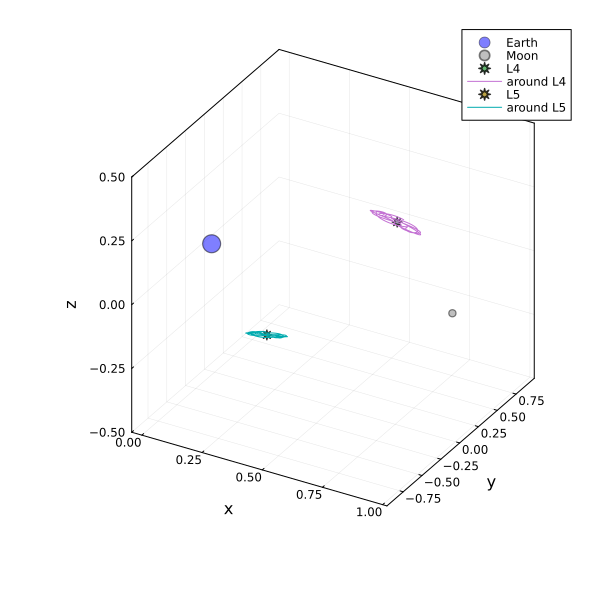

In [13]:
SHIFT_SCALE = 6e-3

plot3d = plot(
    xlabel="x", ylabel="y", zlabel="z",
    size=(600, 600), framestyle = :box,#  aspect_ratio=:equal
    # xlims=(-0.1, 1), ylims=(-1.3, 1.3),
    zlims=(-0.5, 0.5)
)

ex, ey, ez = earth_moon.pos1
scatter!(plot3d, [ex], [ey], [ez], label="Earth", color="blue", markersize=10, alpha=0.5)
mx, my, mz = earth_moon.pos2
scatter!(plot3d, [mx], [my], [mz], label="Moon", color="gray", markersize=4, alpha=0.5)

for (i,lp) in enumerate(stable_Lagrange_points(earth_moon))
    name = "L"*string(i + 3)
    scatter!(plot3d, [lp[1]], [lp[2]], [lp[3]], label=name, markershape=:star2, markersize=5, alpha=0.8)

    path = solve_CR3BP(
        earth_moon,
        init_pos = lp + rand(3) * SHIFT_SCALE,
        init_vel = zeros(3),
        duration = 2π * 10,
        integrator_params = ParamsDOPRI5(ε = 1e-9, h0 = 0.01)
    )
    plot!(plot3d, path.y[:, 1], path.y[:, 2], path.y[:, 3], label="around "*name)
end

display(plot3d)